In [ ]:
import JSSP
import numpy as np
import gym
import numpy as np
import matplotlib.pyplot as plt

# Environment Initialization

In [ ]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [ ]:
# small environment: 2 jobs 3 machines 3 operations
env_s = create_env("instance1.txt") # -53
# medium environment: 6 jobs 6 machines 6 operations
env_m = create_env("instance5.txt") # -55
# large environment: 10 jobs 6 machines 6 operations
env_l = create_env("instance4.txt") # -42
# extra large environment: 10 jobs 11 machines 10 operations
env_xl = create_env("instance3.txt") # -959

# Algorithms

## Random Sampling

In [ ]:
def random_sampling(env, episodes, print_steps = False):
    """
    baseline solution to FJSSP, randomly selects actions for each episode and selects
    best set of actions
    :param print_steps: boolean dictating whether to print each step
    :param env: FJSSP environment
    :param episodes: number of episodes
    :return:
    """
    env.reset()
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    for episode in range(1, episodes+1):
        env.reset()
        done = False
        score = 0
        action_list = []
        time_list = []
        while not done:
            #env.render()
            action = env.action_space.sample()
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
            n_state, reward, done, info = env.step(action)
            score+=reward
        if print_steps:
            print('Episode:{} Total_reward:{}'.format(episode, score))
        if score >= max_score:
            max_score = score
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    return max_score, max_action_list, max_time_list

## Q-Learning

In [ ]:
def policy(state, Q, epsilon, num_actions):
    """
    function that returns the probability for action choosing based on a given Q-function and epsilon at this state
    :param state: tuple of order 2 * number of jobs
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param epsilon: for epsilon greedy choosing algorithm
    :param num_actions: number of legal actions at this state
    :return: an array of order num_actions containing probability for action choosing at this state
    """
    # if state has been visited before, use epsilon greedy algorithm to generate probability
    if state in Q:
        best_action = np.argmax(Q[state])
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    # if state hasn't been visited before, choose action with equal probability
    Action_probabilities = np.ones(num_actions, dtype = float) / num_actions
    return Action_probabilities

In [ ]:
def update_estimation(Q_estimation, estimation_list, total_reward):
    """
    update the Q_estimation table
    1. If state action pair is not estimated, set its Q value
    2. If pair has been estimated, only update in case of a more optimal reward
    :param total_reward: total reward of single episode run
    :param Q_estimation: estimation of Q values table
    :param estimation_list: list of [state, action, reward]
    :return: updated Q_estimation table
    """
    current_reward = total_reward
    for state, action, reward in estimation_list:
        state_action_estimation = Q_estimation[state][action]
        # 1. if state action pair hasn't been estimated
        if state_action_estimation == 0:
            Q_estimation[state][action] = current_reward
        # 2. if current estimation is a more optimal solution
        elif state_action_estimation <= current_reward:
            Q_estimation[state][action] = current_reward
        current_reward -= reward

    return Q_estimation


In [ ]:
def q_estimation(env, epis, epsilon = .9, print_steps = False):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    Once an episode is done, from first state, action pair to the last one:
    1. check if current q value is greater than reward estimation
    2. if yes, update the q value <- reward estimation
    3. if no, reward estimation -= current reward of state action pair
    :param print_steps: boolean dictating whether to print each step
    :param epsilon: randomness factor, how random the selection is
    :param env: JSSP instance
    :param epis: number of episodes
    :return: Filled Q_table with estimations
    """
    max_score = -100000
    max_episode = -1
    # 1. Load Environment and Q-table structure
    Q_estimation = {}
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = [] # rewards per 100 episodes
    max_action_list = []
    max_time_list = []
    decay_rate = epsilon / (epis * .9)

    # Q-learning Algorithm
    for episode in range(epis+1):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        estimation_list = []
        action_list = []
        time_list = []
        # Testing:
        if episode % 100 == 0:
            while not done:
                if state not in Q_estimation:
                    Q_estimation[state] = np.zeros(env.action_space.n)
                # best action from training
                action = np.argmax(Q_estimation[state])
                # update action history
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                # get new state & reward from environment
                next_state, reward, done, _ = env.step(action)
                # store state, action, reward for current episode
                # used for q value estimation
                estimation_list.append([state, action, reward])
                total_reward += reward
                state = next_state
            # update Q_estimation table
            Q_estimation = update_estimation(Q_estimation, estimation_list, total_reward)
            # keep policy testing results every 100 episodes
            testing_reward_list.append(total_reward)
            if print_steps:
                print("Episode: " + str(episode) + " has time " + str(env.time) + " has reward " + str(total_reward))
            # keep track of the optimal policy
            if total_reward >= max_score:
                max_score = total_reward
                max_episode = episode
                max_action_list = action_list
                max_time_list = time_list
            continue

        # Epsilon decay
        if epsilon > decay_rate:
            epsilon -= decay_rate
        # Training
        while not done:
            if state not in Q_estimation:
                Q_estimation[state] = np.zeros(env.action_space.n)
            # generate action choosing probability and choose an action
            # if this is a testing episode, epsilon = 0
            action_probabilities = policy(state, Q_estimation, epsilon, env.action_space.n)
            action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
            # get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            # store state, action, reward for current episode
            # used for q value estimation
            estimation_list.append([state, action, reward])
            total_reward += reward
            state = next_state
        Q_estimation = update_estimation(Q_estimation, estimation_list, total_reward)
        total_reward_list.append(total_reward)

    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    return total_reward_list, testing_reward_list, max_score, max_action_list, max_time_list

# training_reward_list, Q_table, testing_reward_list = q_estimation(env3, 30000)

# Analysis

In [93]:
def plot_learning(plot_list, title):
    plt.plot(plot_list)
    plt.title("QLearning: " + title)
    plt.xlabel("Episode #")
    plt.ylabel("Total_reward")
    plt.show()

In [94]:
def print_allocations(action_list, time_list):
    for i in range(len(action_list)):
        print('The allocation chose at time {} is {}'.format(time_list[i], action_list[i]))

In [97]:
env_names = ["Small", "Medium", "Large", "Extra Large"]
env_list = [env_s, env_m, env_l, env_xl]
env_episodes = [500, 5000, 10000, 50000]

## Random Sampling solutions

In [100]:
solutions_rs = [0]*4
for i in range(4):
    print('Solution found by random selection for {} environment'.format(env_names[i]))
    solutions_rs[i] = random_sampling(env_list[i], env_episodes[i])

Solution found by random selection for Small environment
From 455th Episode best policy has reward -53
Solution found by random selection for Medium environment
From 800th Episode best policy has reward -58
Solution found by random selection for Large environment
From 1889th Episode best policy has reward -47
Solution found by random selection for Extra Large environment
From 40374th Episode best policy has reward -990


## Q-Learning solutions

In [ ]:
solutions_ql = [0]*4
solutions_action_list_ql = [[]]*4
solutions_time_list_ql = [[]]*4
training_lists = [[]]*4
testing_lists = [[]]*4

Solution found by Q_learning for Small environment
From 500th Episode best policy has reward -53
Training plot for Small environment


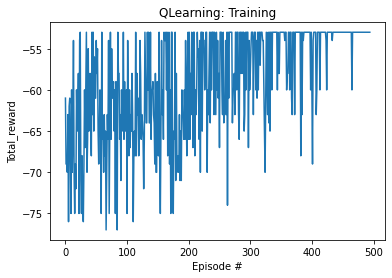

Testing plot for Small environment


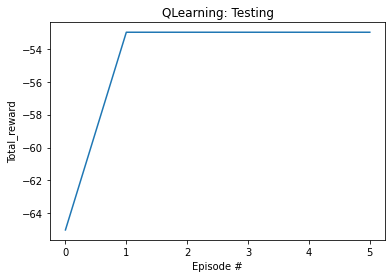

Solution found by Q_learning for Medium environment
From 5000th Episode best policy has reward -55
Training plot for Medium environment


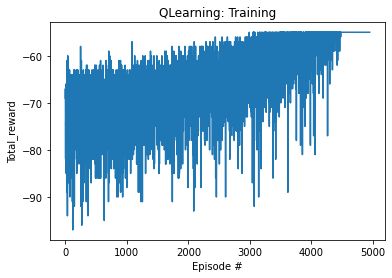

Testing plot for Medium environment


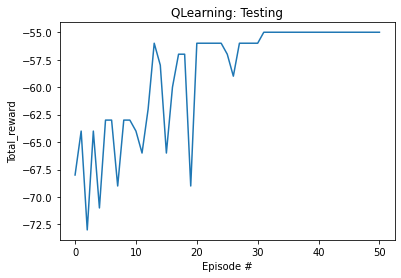

Solution found by Q_learning for Large environment
From 10000th Episode best policy has reward -42
Training plot for Large environment


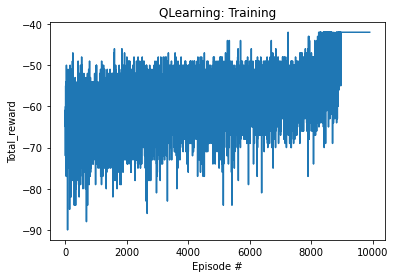

Testing plot for Large environment


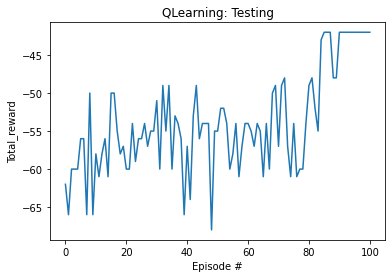

Solution found by Q_learning for Extra Large environment
From 50000th Episode best policy has reward -977
Training plot for Extra Large environment


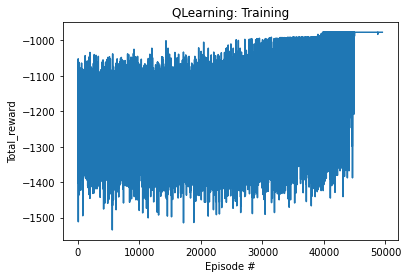

Testing plot for Extra Large environment


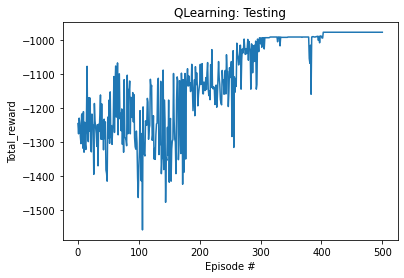

In [99]:
for i in range(4):
    print('Solution found by Q_learning for {} environment'.format(env_names[i]))
    training_lists[i], testing_lists[i], solutions_ql[i], solutions_action_list_ql[i], solutions_time_list_ql[i] = q_estimation(env_list[i], env_episodes[i])
    print('Training plot for {} environment'.format(env_names[i]))
    plot_learning(training_lists[i], "Training")
    print('Testing plot for {} environment'.format(env_names[i]))
    plot_learning(testing_lists[i], "Testing")

In [ ]:
training_lists[0], testing_lists[0], solutions_ql[0], solutions_action_list_ql[0], solutions_time_list_ql[0] = q_estimation(env_s, 500)
plot_learning(training_lists[0], "Training")
plot_learning(testing_lists[0], "Testing")

In [ ]:
training_lists[1], testing_lists[1], solutions_ql[1], solutions_action_list_ql[1], solutions_time_list_ql[1] = q_estimation(env_m, 5000)
plot_learning(training_lists[1], "Training")
plot_learning(testing_lists[1], "Testing")

In [91]:
training_lists[2], testing_lists[2], solutions_ql[2], solutions_action_list_ql[2], solutions_time_list_ql[2] = q_estimation(env_l, 10000)
plot_learning(training_lists[2], "Training")
plot_learning(testing_lists[2], "Testing")

KeyboardInterrupt: 

In [ ]:
training_lists[3], testing_lists[3], solutions_ql[3], solutions_action_list_ql[3], solutions_time_list_ql[3] = q_estimation(env_xl, 50000)
plot_learning(training_lists[3], "Training")
plot_learning(testing_lists[3], "Testing")

## Comparison

### Makespan Comparison Table

| Env/Algo  | Random Selection | Q_Learning |
|-----------|------------------|------------|
| Small     | 53               | 53         |
| Medium    | 58               | 55         |
| Large     | 47               | 42         |
| Extra Large | -990             | 977        |

### Solutions for environments

#### Small Environment - 2 jobs 3 machines 3 operations

In [92]:
print_allocations(solutions_action_list_ql[0], solutions_time_list_ql[0])

The allocation chose at time 0 is [1 0]
The allocation chose at time 15 is [ 2 -1]
The allocation chose at time 20 is [-1  1]
The allocation chose at time 38 is [-1  1]


#### Medium Environment - 6 jobs 6 machines 6 operations

In [91]:
print_allocations(solutions_action_list_ql[1], solutions_time_list_ql[1])

#### Large Environment - 10 jobs 6 machines 6 operations

In [91]:
print_allocations(solutions_action_list_ql[2], solutions_time_list_ql[2])

#### Extra Large Environment - 10 jobs 11 machines 10 operations

In [91]:
print_allocations(solutions_action_list_ql[3], solutions_time_list_ql[3])